In [1]:
# coding: utf-8
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe  ##!! important

tf.enable_eager_execution()

In [2]:
print('TensorFlow version: {}'.format(tf.VERSION))
print('Eager execution: {}'.format(tf.executing_eagerly()))

TensorFlow version: 1.9.0
Eager execution: True


## Iris鸢尾花分类问题

### 下载数据

In [4]:
train_dataset_url = 'http://download.tensorflow.org/data/iris_training.csv'
train_dataset_fp = tf.keras.utils.get_file(
    fname=os.path.basename(train_dataset_url), origin=train_dataset_url
)
print('Local copy of the dataset file: {}'.format(train_dataset_fp))

Local copy of the dataset file: /home/zz/.keras/datasets/iris_training.csv


### 解析数据
返回(features, label)元组

In [8]:
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0]]  # 设定默认值
    parsed_line = tf.decode_csv(line, example_defaults)
    # 前四列是特征。整到一起。
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    # 最后一列是label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

## 搞数据集

In [9]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1).map(parse_csv).shuffle(buffer_size=1000).batch(32)

In [11]:
#features, label = iter(train_dataset).next()
#print('example features:', features[0])
#print('exampole label:', label[0])

## 创建模型

In [20]:
# 3个全连接层。用keras了。anyway，能出活儿就是好东西
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)), 
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

## 定义损失函数和梯度函数

In [15]:
def loss(model, x, y):
    y_ = model(x)
    # y是gt label，y和y_的编码形式为一个整数，代表类别索引。所以，使用tf.losses.sparse_softmax_cross_entropy
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    """计算梯度。这个函数的细节不太懂。返回什么？输入什么？"""
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

## 创建优化器

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

## 循环训练

In [21]:
# 记录每个epoch的loss,用于绘图。不用tensorboard嘛？
train_loss_results = []
train_accuracy_results = []

num_epochs = 201
for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    # Training loop, batch size 32
    for x, y in train_dataset:
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())
        
        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.413, Accuracy: 35.000%
Epoch 050: Loss: 0.774, Accuracy: 70.000%
Epoch 100: Loss: 0.504, Accuracy: 70.000%
Epoch 150: Loss: 0.347, Accuracy: 91.667%
Epoch 200: Loss: 0.249, Accuracy: 95.833%


## 可视化损失函数vs.迭代次数变化趋势：用matplotlib

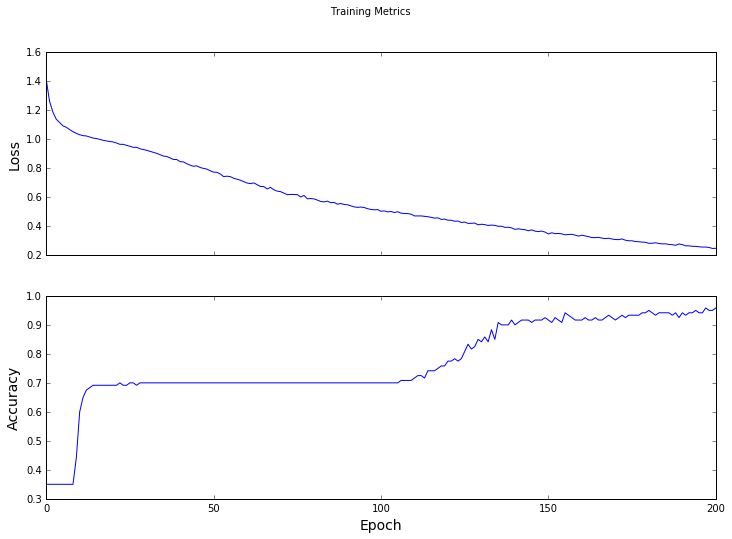

In [22]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel('Loss', fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

## 评估模型训练效果
下载测试数据集，然后测评。

In [24]:
test_url= 'http://download.tensorflow.org/data/iris_test.csv'
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1).map(parse_csv).shuffle(1000).batch(32)

In [25]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print('Test set accuracy: {:.3f}%'.format(test_accuracy.result()))

Test set accuracy: 0.933%


## 使用训练好的模型预测

In [26]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
